In [6]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicHermiteSpline
import matplotlib.pyplot as plt
import progressbar

plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

In [91]:
def true_func(t):
    return (np.cos(t) + np.sin(t))/10 - (17/10)*np.exp(-3*t) + (26/10)*np.exp(-2*t)

In [70]:
def system_first_order(t, y):
    W = np.array([[0, 1], [-6, -5]])
    b = np.array([0, np.cos(t)])
    return W.dot(y) + b

First, in order to ensure that the system is implemented correctly, use it with scipy's built-in solver

In [9]:
sol = solve_ivp(system_first_order, [0, 20], [1, 0], dense_output=True)

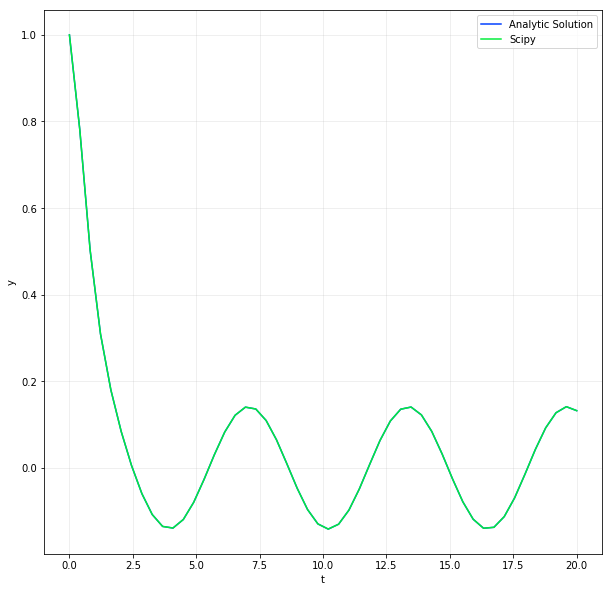

In [93]:
ts = np.linspace(0, 20)
plt.plot(ts, true_func(ts), label='Analytic Solution')
plt.plot(ts, sol.sol(ts)[0], label='Scipy')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

In [179]:
class ButcherRK45:
    """Custom butcher array"""
    c = [1/3, 2/3, 1]
    A = [ [1/3], [-1/3, 1], [1, -1, 1]]
    b = [1/8, 3/8, 3/8, 1/8]

In [204]:
def rk45(f, tspan, y0, h=0.1, dense_output=False, butcher=ButcherRK45):
    if len(tspan) != 2:
        raise ValueError("tspan must be array of length 2")

    a, b = tspan[0], tspan[1]
    # Initialize
    t = a
    w = y0
    tHist = [t]
    wHist = [w]
    dydtHist = []
    
    # Get butcher array
    c, A, weights = butcher.c, butcher.A, butcher.b
    c = np.asarray(c)
    A = np.asarray(A)
    weights = np.atleast_1d(np.asarray(weights))

    # Order of RK being done
    s = weights.size
    # Intermediate matrix
    k = np.zeros((s, 2))

    # Main loop
    while t < b :
        # Make sure we don't go over
        tNext = min(t+h,b)
        hh = tNext - t
        dydt = f(t, w)

        # RK written out
        # k[0]  = hh * f(t, w)
        # k[1]  = hh * f(t + c[0]*hh, w + A[0]*k[0])
        # k[2]  = hh * f(t + c[1]*hh, w + A[1][0]*k[0] + A[1][1]*k[1])
        # k[3]  = hh * f(t + c[2]*hh, w + A[2][0]*k[0] + A[2][1]*k[1] + A[2][2]*k[2])
        # w = w + weights[0]*k[0] + weights[1]*k[1] + weights[2]*k[2] + weights[3]*k[3]
        
        k[0]  = hh*dydt
        for j in range(1,s):
            k[j] = hh*f(t + hh*c[j-1], w + np.dot(A[j-1], k[:j]))            
        
        w = w + np.dot(weights, k)
        t = tNext

        # Update history
        if dense_output:
            tHist.append(t)
            wHist.append(w)
            dydtHist.append(dydt)
    dydtHist.append(f(t,w))

    # Interpolate history
    if dense_output:
        sol = CubicHermiteSpline(tHist,wHist,dydtHist)
        return np.array(wHist), sol

    return t, w

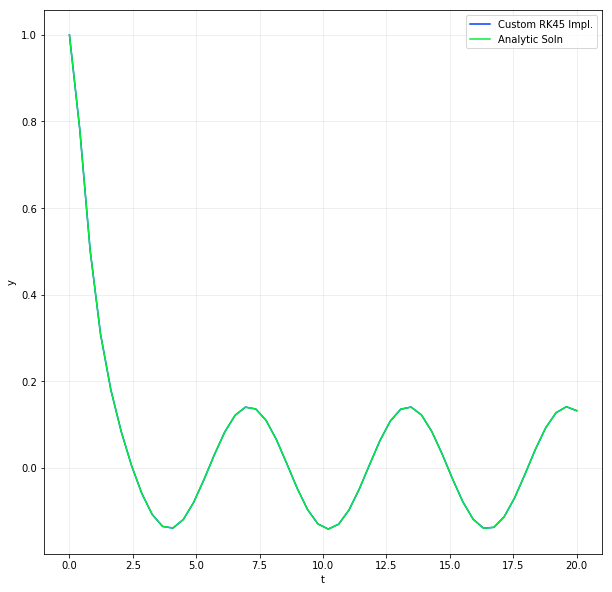

In [205]:
ws, rk_sol = rk45(system_first_order, [0, 20], np.array([1, 0]).T, h=0.1, dense_output=True)
plt.plot(ts, rk_sol(ts)[:,0], label='Custom RK45 Impl.')
plt.plot(ts, true_func(ts), label='Analytic Soln')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

In [211]:
hs = np.logspace(-1, -5, 10)
true_val = true_func(20)
errors = []
for h in hs:
    last_t, last_w = rk45(system_first_order, [0, 20], np.array([1, 0]).T, h=h, dense_output=False)
    print(last_t)
    errors.append(np.abs(true_val - last_w[0]))

20
20
20
20
20
20
20
20
20
20


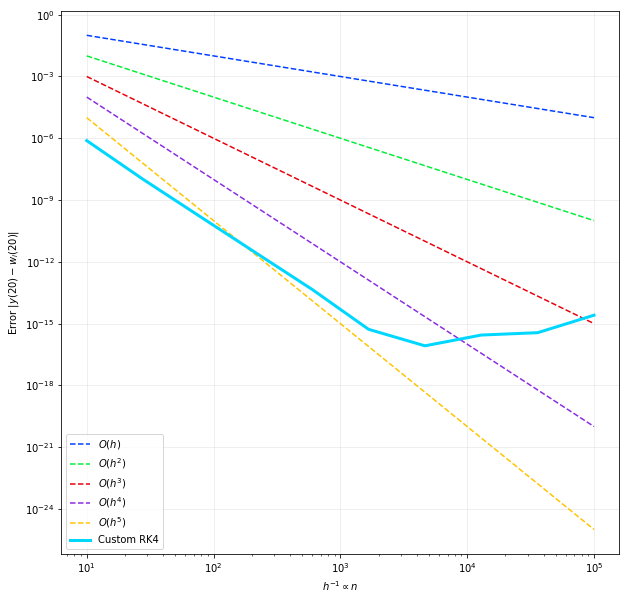

In [212]:
plt.loglog(1/hs, hs,'--',label='$O(h)$')
plt.loglog(1/hs, hs**2,'--',label='$O(h^2)$')
plt.loglog(1/hs, hs**3,'--',label='$O(h^3)$')
plt.loglog(1/hs, hs**4,'--',label='$O(h^4)$')
plt.loglog(1/hs, hs**5,'--',label='$O(h^5)$')
plt.loglog(1/hs, errors, linewidth=3, label='Custom RK4')
plt.ylabel('Error $|y(20) - w_i(20)|$')
plt.xlabel('$h^{-1} \propto n$')
plt.legend()
plt.show()

The order of the custom RK implementation seems to be around $O(h^4)$. The order begins to increase at some point, most likely due to underflow